In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import random
import math
from tqdm import tqdm

from DynamicalSystemLayer import *
from VaeNeuralODELayer import *

# Data generation

In [103]:
p = torch.Tensor([[0., 1., -0.05, 0]])
z0 = torch.Tensor([[0., 1.]])

times = torch.from_numpy(np.arange(0,200))

ode_true = VaeNeuralODE(LinearODEF(p))
obs = ode_true(z0, times, return_whole_sequence=True).detach()
obs = obs.squeeze(1)

In [104]:
obs.shape

torch.Size([200, 2])

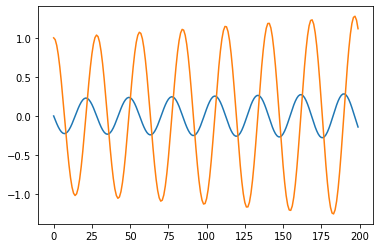

In [106]:
plt.plot(obs[:,0].detach().numpy())
plt.plot(obs[:,1].detach().numpy())
plt.show()

In [96]:
pend_data = obs
window_len = 5
window_set = pend_data.view(40, 5, 2)
times_set = times.view(40, 5)

In [95]:
x = torch.randn(200,2)
y = x.view(40, 5, 2)
y[0,0]

tensor([ 0.2651, -1.1379])

In [97]:
window_set.shape

torch.Size([40, 5, 2])

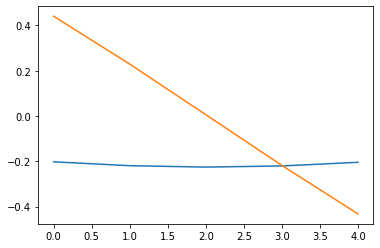

In [100]:
plt.plot(window_set[1,:,0].detach().numpy())
plt.plot(window_set[1,:,1].detach().numpy())
plt.show()

# Model

In [119]:
class LinearODEFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x0, t, A):
        time_len = t.size(0)
        x_dim = x0.size(0)
        z = torch.zeros(time_len, 2)
        z0 = x0
        with torch.no_grad():
            for it in range(time_len-1):
                #h = t[it+1] - t[it]
                z0 = z0 + A.matmul(z0)
                z[it+1] = z0

        ctx.save_for_backward(A.clone(), z.clone(), t)  
        return z
    
    @staticmethod
    def backward(ctx, grad_out):
        A, z, t = ctx.saved_tensors
        time_len = t.size(0)
        z_dim = z.size(1)
        grad_in = grad_out.clone()
        n_param = grad_in.shape[1]
        
        #adzdA = torch.zeros(time_len, n_param)
        u = torch.zeros(z_dim, n_param)
        for it in range(time_len-1, 1 ,-1):
            zi = z[it-1].view(1, z_dim)
            #ti = t[it]
            ai = grad_in[it].view(grad_in.shape[1],1)
            #h = ti - t[it-1]
            u += ai.matmul(zi)
            #adzdA[it] = u
        print(u)
        return u, None, None
         

In [213]:
#for later
class LinearODELayer(nn.Module):
    def __init__(self, data_dim):
        super(LinearODELayer, self).__init__()
        self.data_dim = data_dim
        self.A = nn.Parameter(torch.Tensor(self.data_dim, self.data_dim))
        
    def forward(self, z0, t):
        #z0 = torch.Tensor([x[0], x[1]])
        z = LinearODEFunction.apply(z0, t, self.A)
        return z

In [88]:
a = torch.randn(2,1)
z = torch.randn(1,2)

In [89]:
a.matmul(z)

tensor([[-0.6406, -0.7222],
        [-1.3856, -1.5620]])

# Training

In [114]:
dtype = torch.float
device = torch.device("cpu")

p = torch.Tensor([[0., 1., -0.05, 0]])
z0 = torch.Tensor([[0., 1.]])

times = torch.from_numpy(np.arange(0,200))

ode_true = VaeNeuralODE(LinearODEF(p))
obs = ode_true(z0, times, return_whole_sequence=True).detach()
obs = obs.squeeze(1)
obs = obs.detach().requires_grad_(True)

pend_data = obs
window_len = 5
window_set = pend_data.view(40, 5, 2)
times_set = times.view(40, 5)



test_set = window_set[30:, :, :]
train_set = window_set[:30,:]

test_time = times_set[30:]
train_time = times_set[:30]

train_sample = train_set.shape[1]
test_sample = test_set.shape[1]

A = torch.randn(2,2, device=device, dtype=dtype, requires_grad=True)

In [124]:
#Crash test
class LinearFunction(Function):

    # Note that both forward and backward are @staticmethods
    @staticmethod
    # bias is an optional argument
    def forward(ctx, x, weight, bias=None):
        ctx.save_for_backward(x, weight.clone(), bias)
        output = weight.matmul(x.t())
        if bias is not None:
            output += bias.unsqueeze(0).expand_as(output)
        return output

    # This function has only a single output, so it gets only one gradient
    @staticmethod
    def backward(ctx, grad_output):
        # This is a pattern that is very convenient - at the top of backward
        # unpack saved_tensors and initialize all gradients w.r.t. inputs to
        # None. Thanks to the fact that additional trailing Nones are
        # ignored, the return statement is simple even when the function has
        # optional inputs.
        x, weight, bias = ctx.saved_tensors
        grad_input = grad_weight = grad_bias = None

        # These needs_input_grad checks are optional and there only to
        # improve efficiency. If you want to make your code simpler, you can
        # skip them. Returning gradients for inputs that don't require it is
        # not an error.
        if ctx.needs_input_grad[0]:
            grad_input = grad_output.mm(weight)
        if ctx.needs_input_grad[1]:
            grad_weight = grad_output.mm(x)
        if bias is not None and ctx.needs_input_grad[2]:
            grad_bias = grad_output.sum(0).squeeze(0)
            
        print('back meth:', grad_weight)

        return grad_input, grad_weight, grad_bias
    
    
x = torch.randn(5,1,2)
y = torch.randn(5,1,2)
y_pred = torch.zeros(5,1,2)
T = 5

w1 = torch.randn(2,2, requires_grad=True)
#w2 = torch.randn(2,2, requires_grad=True)

lin = LinearFunction.apply
learning_rate = 0.1
for epoch in range(10):
    with torch.autograd.set_detect_anomaly(True):
        pred = x[0]
        y_pred[0] = pred
        for t in range(T-1):
            xt = x[t]
            pred = lin(xt, w1)
            y_pred[t+1] = pred.t()

        loss = (y_pred - y).pow(2).sum()
        loss.backward(retain_graph=True)
        print('grad in train:',w1.grad)

    # Update weights using gradient descent
    with torch.no_grad():
        w1 -= learning_rate * w1.grad
        #w2 -= learning_rate * w2.grad
        #print('w1',w1)
        #print('w2',w2)
        

        # Manually zero the gradients after updating weights
        w1.grad.zero_()
        #w2.grad.zero_()

back meth: tensor([[ 0.6007, -0.3874],
        [ 0.6298, -0.4061]])
back meth: tensor([[-0.2445, -0.7149],
        [ 1.6363,  4.7854]])
back meth: tensor([[-1.1238, -1.0039],
        [ 6.0166,  5.3749]])
back meth: tensor([[-2.1078, -0.5651],
        [ 1.2752,  0.3419]])
grad in train: tensor([[-2.8754, -2.6713],
        [ 9.5579, 10.0961]])
back meth: tensor([[ 0.7497, -0.4835],
        [ 0.2358, -0.1520]])
back meth: tensor([[0.0404, 0.1180],
        [0.5948, 1.7394]])
back meth: tensor([[0.2853, 0.2549],
        [1.0417, 0.9305]])
back meth: tensor([[-1.3591, -0.3644],
        [-1.2814, -0.3435]])
back meth: tensor([[0., -0.],
        [0., -0.]])
back meth: tensor([[-0., -0.],
        [-0., -0.]])
back meth: tensor([[0., 0.],
        [0., 0.]])
back meth: tensor([[-0., -0.],
        [-0., -0.]])
grad in train: tensor([[-0.2837, -0.4750],
        [ 0.5908,  2.1743]])
back meth: tensor([[ 0.7468, -0.4816],
        [ 0.3407, -0.2197]])
back meth: tensor([[0.0849, 0.2484],
        [0.40

In [52]:
y_pred[0].shape

torch.Size([1, 2])

In [85]:
print('Hello')
learning_rate = 0.1
train_loss = 0
test_loss = 0
train_loss_store = []
test_loss_store = []
loss_fn = nn.MSELoss()

print('start training')
for epoch in range(100):
    ode = LinearODEFunction.apply
    
    for n in range(train_sample):
        ytrain = train_set[n,:,:]
        z0 = torch.Tensor([ytrain[0,0], ytrain[0, 1]])
        t = train_time[n,:]
        ztrain = ode(z0, t, A)
        
        #loss = (ztrain - ytrain).pow(2).sum()
        loss = loss_fn(ztrain, ytrain)
        train_loss += loss.item()
        loss.backward()
        
        with torch.no_grad():
            A -= learning_rate*A.grad
            A.grad.zero_()
            
    for n in range(test_sample):
        with torch.no_grad():
            ytest = test_set[n,:,:]
            z0 = torch.Tensor([ytest[0,0], ytest[0,1]])
            t = test_time[n,:]
            ztest = ode(z0, t, A)
            
            #loss = (ztest - ytest).pow(2).sum()
            loss = loss_fn(ztest, ytest)
            test_loss += loss.item()
            
    train_loss_store.append(train_loss)
    test_loss_store.append(test_loss)
    print('epoch:', epoch+1)
    print('train_loss:', train_loss)
    print('test_loss:', test_loss)
    print('predicted A:')
    print(A)
    if epoch%10 == 0:
        plt.plot(t.numpy(), ytest[:,0].detach().numpy(), label='Ground Truth')
        plt.plot(t.numpy(), ztest[:,0].detach().numpy(), label='Predicted');
        plt.legend()
        plt.show()
print('...training complete')        
plt.plot(train_loss_store, label='training loss')
plt.plot(test_loss_store, label='test loss')
plt.show()
    

Hello
start training


TypeError: unsupported operand type(s) for *: 'float' and 'NoneType'

In [177]:
A

tensor([[ 0.0321, -0.0059],
        [ 0.0682,  0.0345]], requires_grad=True)

In [122]:
print('start training')
for epoch in range(5):
    ode = LinearODEFunction.apply
    
    for n in range(train_sample):
        ytrain = train_set[n,:,:]
        z0 = torch.Tensor([ytrain[0,0], ytrain[0, 1]])
        t = train_time[n,:]
        ztrain = ode(z0, t, A)
        
        #loss = (ztrain - ytrain).pow(2).sum()
        loss = loss_fn(ztrain, ytrain)
        #train_loss += loss.item()
        loss.backward()
        print(A.grad)

start training
tensor([[ 98.8130, -13.8295],
        [-11.3519,   1.5852]])
tensor([[0., 0.],
        [0., 0.]])
tensor([[59.2239, -8.2826],
        [-9.3418,  1.3064]])
tensor([[0., 0.],
        [0., 0.]])
tensor([[10.8214, -1.5171],
        [-0.2947,  0.0391]])
tensor([[0., 0.],
        [0., 0.]])
tensor([[114.2538, -15.9884],
        [-13.9609,   1.9504]])
tensor([[0., 0.],
        [0., 0.]])
tensor([[36.9698, -5.1689],
        [-6.4560,  0.9028]])
tensor([[0., 0.],
        [0., 0.]])
tensor([[ 98.8130, -13.8295],
        [-11.3519,   1.5852]])
tensor([[0., 0.],
        [0., 0.]])
tensor([[59.2239, -8.2826],
        [-9.3418,  1.3064]])
tensor([[0., 0.],
        [0., 0.]])
tensor([[10.8214, -1.5171],
        [-0.2947,  0.0391]])
tensor([[0., 0.],
        [0., 0.]])
tensor([[114.2538, -15.9884],
        [-13.9609,   1.9504]])
tensor([[0., 0.],
        [0., 0.]])
tensor([[36.9698, -5.1689],
        [-6.4560,  0.9028]])
tensor([[0., 0.],
        [0., 0.]])
tensor([[ 98.8130, -13.8295],

In [89]:
A

tensor([[2.0170, 0.7242],
        [0.1959, 0.4952]], requires_grad=True)